In [1]:
confirmed_cases_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
recovered_cases_url ="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
death_cases_url ="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv"

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
def get_n_melt_data(data_url,case_type):
    df = pd.read_csv(data_url)
    melted_df = df.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'])
    melted_df.rename(columns={"variable":"Date","value":case_type},inplace=True)
    return melted_df

def merge_data(confirm_df,recovered_df,deaths_df):
    new_df = confirm_df.join(recovered_df['Recovered']).join(deaths_df['Deaths'])
    return new_df

In [4]:
confirm_df = get_n_melt_data(confirmed_cases_url,"Confirmed")
recovered_df = get_n_melt_data(recovered_cases_url,"Recovered")
deaths_df = get_n_melt_data(death_cases_url,"Deaths")

In [5]:
confirm_df.tail()

,Province/State,Country/Region,Lat,Long,Date,Confirmed
31915,NaN,Sao Tome and Principe,0.186360,6.613081,5/20/20,251
31916,NaN,Yemen,15.552727,48.516388,5/20/20,184
31917,NaN,Comoros,-11.645500,43.333300,5/20/20,34
31918,NaN,Tajikistan,38.861034,71.276093,5/20/20,2140
31919,NaN,Lesotho,-29.609988,28.233608,5/20/20,1


In [6]:
df = merge_data(confirm_df,recovered_df,deaths_df)

In [7]:
df.head()

,Province/State,Country/Region,Lat,Long,Date,Confirmed,Recovered,Deaths
0,NaN,Afghanistan,33.0000,65.0000,1/22/20,0,0.0,0
1,NaN,Albania,41.1533,20.1683,1/22/20,0,0.0,0
2,NaN,Algeria,28.0339,1.6596,1/22/20,0,0.0,0
3,NaN,Andorra,42.5063,1.5218,1/22/20,0,0.0,0
4,NaN,Angola,-11.2027,17.8739,1/22/20,0,0.0,0


In [8]:
df_per_day = df.groupby("Date")[['Confirmed','Recovered', 'Deaths']].sum()

In [9]:
df_per_day

,Confirmed,Recovered,Deaths
Date,,,
1/22/20,555,28.0,17
1/23/20,654,30.0,18
1/24/20,941,36.0,26
1/25/20,1434,43.0,42
1/26/20,2118,102.0,56
...,...,...,...
5/5/20,3662691,1428392.0,257239
5/6/20,3756069,1671443.0,263855
5/7/20,3845718,1539028.0,269567


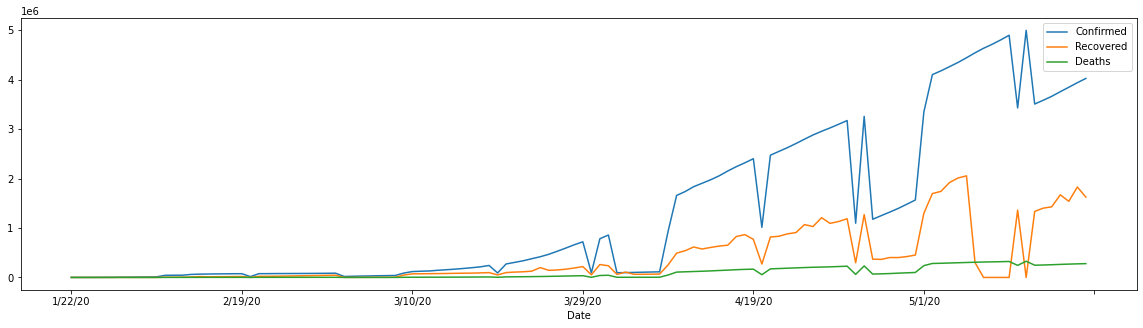

In [10]:
df_per_day.plot(kind='line',figsize=(20,5))

In [11]:
import fbprophet
from fbprophet import Prophet
m = Prophet()

In [12]:
m.add_seasonality(name="monthly",period=30.5,fourier_order=5)

In [13]:
global_cases = df_per_day.reset_index()

In [14]:
confirmed_cases = global_cases[["Date","Confirmed"]]
recovered_cases = global_cases[["Date","Recovered"]]
total_deaths = global_cases[["Date","Deaths"]]

In [ ]:
confirmed_cases.rename(columns={"Date":"ds","Confirmed":"y"},inplace=True)

In [ ]:
recovered_cases.rename(columns={"Date":"ds","Recovered":"y"},inplace=True)

In [15]:
total_deaths.rename(columns={"Date":"ds","Deaths":"y"},inplace=True)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/core/frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [ ]:
train = confirmed_cases[:120]
test = confirmed_cases[80:]

In [16]:
total_deaths

,ds,y
0,1/22/20,17
1,1/23/20,18
2,1/24/20,26
3,1/25/20,42
4,1/26/20,56
...,...,...
115,5/5/20,257239
116,5/6/20,263855
117,5/7/20,269567
118,5/8/20,274898


In [17]:
m.fit(total_deaths)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [30]:
future_dates = m.make_future_dataframe(periods=150)

In [31]:
prediction =  m.predict(future_dates)

In [32]:
prediction[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2020-01-22,-4.931569e+01,-778.957221,5.402986e+02
1,2020-01-23,2.866491e+02,-333.971646,9.552315e+02
2,2020-01-24,4.626737e+02,-142.148007,1.099106e+03
3,2020-01-25,1.803699e+02,-440.217204,8.382232e+02
4,2020-01-26,-4.896396e+02,-1147.303623,1.152386e+02
...,...,...,...,...
265,2020-10-13,1.051897e+06,668204.025958,1.419273e+06
266,2020-10-14,1.056930e+06,668998.092749,1.428184e+06
267,2020-10-15,1.062057e+06,670329.226542,1.433970e+06
268,2020-10-16,1.067075e+06,673636.043692,1.442086e+06


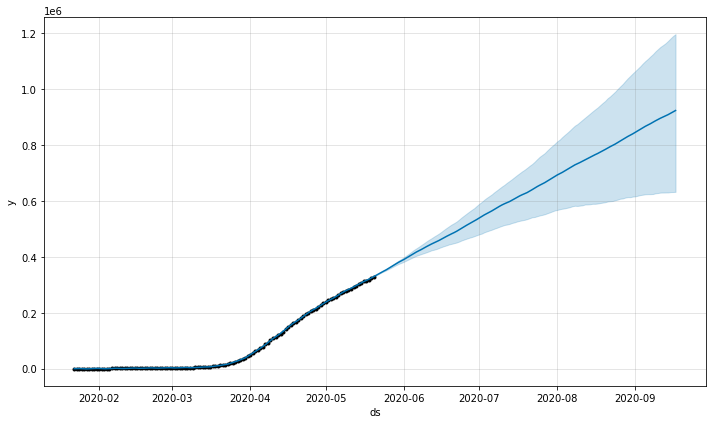

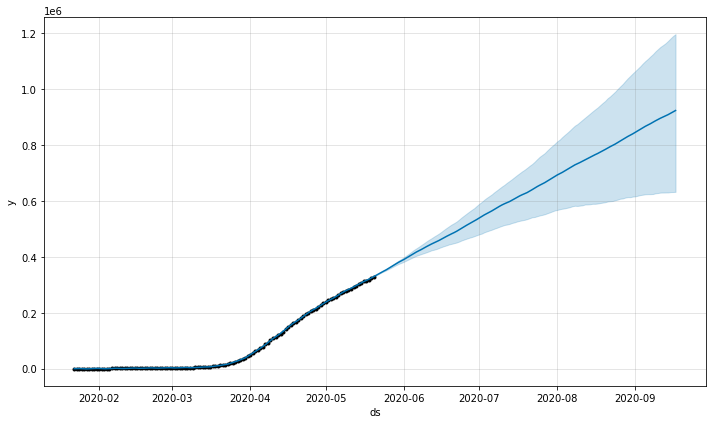

In [29]:
m.plot(prediction)

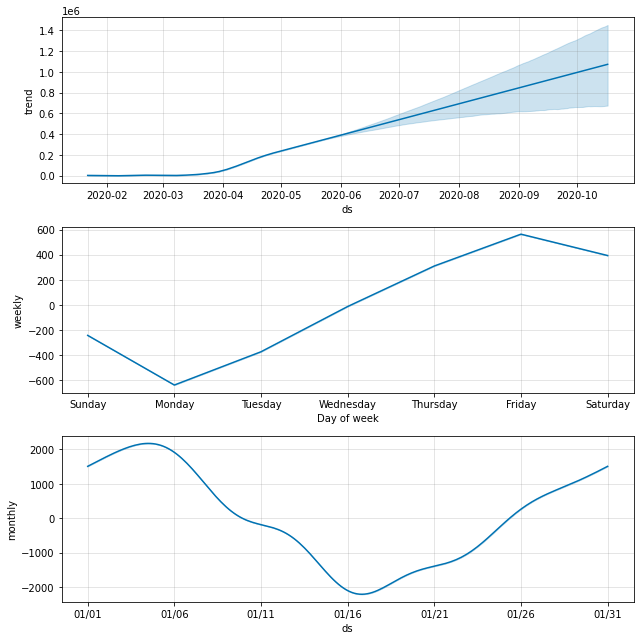

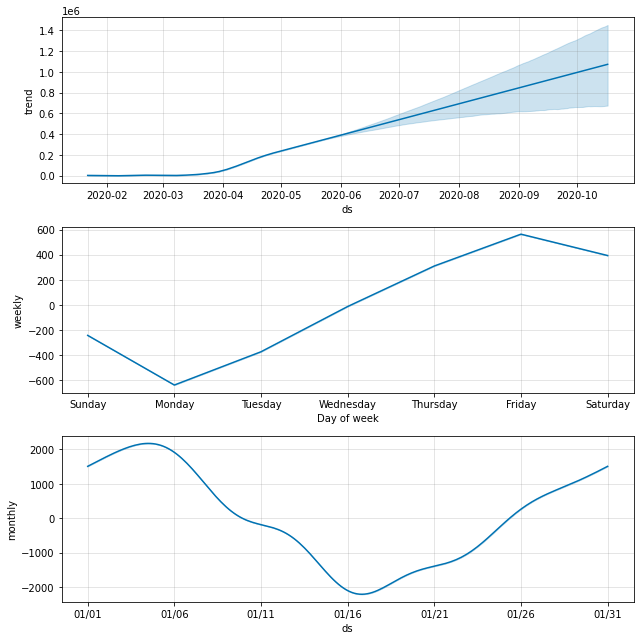

In [33]:
m.plot_components(prediction)

In [ ]:
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

In [ ]:
trace = go.Scatter(
    name = 'Actual price',
    mode = 'markers',
    x = list(df_forecast['ds']),
    y = list(df['y']),
    marker=dict(
        color='#FFBAD2',
        line=dict(width=1)
    )
)

In [ ]:
trace1 = go.Scatter(
    name = 'trend',
    mode = 'lines',
    x = list(df_forecast['ds']),
    y = list(df_forecast['yhat']),
    marker=dict(
        color='red',
        line=dict(width=3)
    )
)

In [ ]:
upper_band = go.Scatter(
    name = 'upper band',
    mode = 'lines',
    x = list(df_forecast['ds']),
    y = list(df_forecast['yhat_upper']),
    line= dict(color='#57b88f'),
    fill = 'tonexty'
)

In [ ]:
lower_band = go.Scatter(
    name= 'lower band',
    mode = 'lines',
    x = list(df_forecast['ds']),
    y = list(df_forecast['yhat_lower']),
    line= dict(color='#1705ff')
)
